In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from trainer import train

plt.rcParams['figure.figsize'] = [14, 8]

In [2]:
class SalesPredictor:
    def __init__(self, period, residuals_model):
        self.period = period
        self.residuals_model = residuals_model
    
    def fit(self, prices, sales):
        decomposition = seasonal_decompose(sales, model='additive', period=self.period)
        self.seasonal, trend, res = decomposition.seasonal, decomposition.trend, decomposition.resid
        self.first_week = weeks_from_date(self.seasonal.index)[0]
        
        trend = trend[~trend.isna()]
        # self._fit_trend(np.arange(trend.shape[0]), trend)
        
        res = res[~res.isna()]
        prices = prices.loc[res.index]
        
        self.residuals_model.fit(
            pd.DataFrame(
                data={
                    "prices": prices.reshape(-1),
                    "week": weeks_from_date(prices.index).reshape(-1)
            }),
            (res + trend).to_numpy().reshape(-1, 1)
        )

    # def _fit_trend(self, x, y):
    #     slope, intercept = np.polyfit(x, y, deg=1)
    #     self.trend_slope = slope
    #     self.trend_intercept = intercept
    
    def _predict_array(self, week, prices, verbose: bool = False):
        seasonal_pred = self.seasonal[(week - self.first_week) % 53]
        # pred_trend = self.trend_slope * week + self.trend_intercept
        
        pred_res = self.residuals_model.predict(
            pd.DataFrame(data={
                    "prices": prices.reshape(-1), 
                    "week": week.reshape(-1), 
            }))
        
        if pred_res.ndim > 1:
            pred_res = pred_res.squeeze(1)
            
        # if verbose:
        #     fig, ax = plt.subplots(3, 1, figsize=(25, 6))
        #     ax[0].plot(prices.index, seasonal_pred)
        #     ax[1].plot(prices.index, pred_trend)
        #     ax[2].plot(prices.index, pred_res)
        #     plt.show()
        
        # return seasonal_pred + pred_trend + pred_res
        return seasonal_pred + pred_res
    
    def predict(self, week, prices, verbose: bool = False):
        if not isinstance(week, np.ndarray) and not isinstance(prices, np.ndarray):
            sales_pred = self._predict_array(np.array([week]), np.array([[prices]]), verbose)
            return sales_pred[0]
        return self._predict_array(week, prices, verbose)


In [3]:
def train(env, agent, episodes, print_every=500):
    cum_rewards = []

    for i in range(episodes):
        reward_sum = 0

        observation = env.reset()
        action = agent.begin_episode(observation)
        done = False

        while not done:
            observation, reward, done = env.step(action)
            action = agent.act(observation, reward, done)
            reward_sum += reward

        cum_rewards.append(reward_sum)
        if i % print_every == 0:
            print(f"Episode {i}; Mean reward = {cum_rewards[-1]}")
    
    return cum_rewards


In [4]:
class MarketEnv:
    def __init__(self, sales_model, prime_cost):
        self.sales_model = sales_model
        self.prime_cost = prime_cost
    
    def reset(self):
        self.t = 1
        return self.t
    
    def step(self, action):
        sales = self.sales_model.predict(self.t, pd.Series(action))
        profit = sales * (action - self.prime_cost)
        self.t += 1

        return pd.Series(self.t), profit, self.t == 53


# Since tabular Q-learning deals with finite state-space, the agent should discretize continious observations.
class MarketAgent:
    def __init__(self, min_price, max_price, bins_number, learning_rate=0.1, discount_factor=0.96,
                 exploration_rate=0.98, exploration_decay_rate=0.99, seasonality_period: int = 52):
        
        self.learning_rate = learning_rate
        self.min_price = min_price
        self.max_price = max_price
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.action_bins_number = bins_number
        
        self.state = None
        self.action = None
        
        self.seasonality_period = seasonality_period
        self.bins = np.linspace(self.min_price, self.max_price, self.action_bins_number)
        self.q = np.zeros((self.seasonality_period, bins_number))
        
    def begin_episode(self, observation):
        self.state = observation % self.seasonality_period
        self.exploration_rate *= self.exploration_decay_rate
        return np.argmax(self.q[self.state])
    
    def act(self, observation, reward, done):
        next_state = observation % self.seasonality_period
        enable_exploration = (1 - self.exploration_rate) <= np.random.uniform(0, 1)
        if enable_exploration:
            next_action = np.random.randint(0, self.action_bins_number)
        else:
            next_action = np.argmax(self.q[next_state])
        self.q[self.state, self.action] = (1 - self.learning_rate) * self.q[self.state, self.action] + \
                                          self.learning_rate * (reward + self.discount_factor * np.max(self.q[next_state]))
        # ====================================================

        self.state = next_state
        self.action = next_action

        return self.bins[next_action]


### Build Environment

Load forecasting model.

In [5]:
model_path = os.path.join("data", "sales_model.pkl")
sales_predictor = pickle.load(open(model_path, "rb"))

In [6]:
prime_cost = 100
min_price, max_price = prime_cost, prime_cost * 6

In [7]:
env = MarketEnv(sales_predictor, prime_cost)

### Train Agent

Tune hyperparameters in order to maximize agent's cummulative reward.

In [11]:
# TODO: Your code here
learning_rate=0.1
discount_factor=0.5
exploration_rate=0.95
exploration_decay_rate=0.95
bins_number=100
episodes=1000

In [12]:
agent = MarketAgent(min_price, max_price, bins_number, learning_rate, discount_factor, exploration_rate,
                    exploration_decay_rate)

In [13]:
cum_rewards = train(env, agent, episodes)

Episode 0; Mean reward = 745465.6729764859
Episode 500; Mean reward = 1098552.5780979067


Text(0, 0.5, 'Mean Reward')

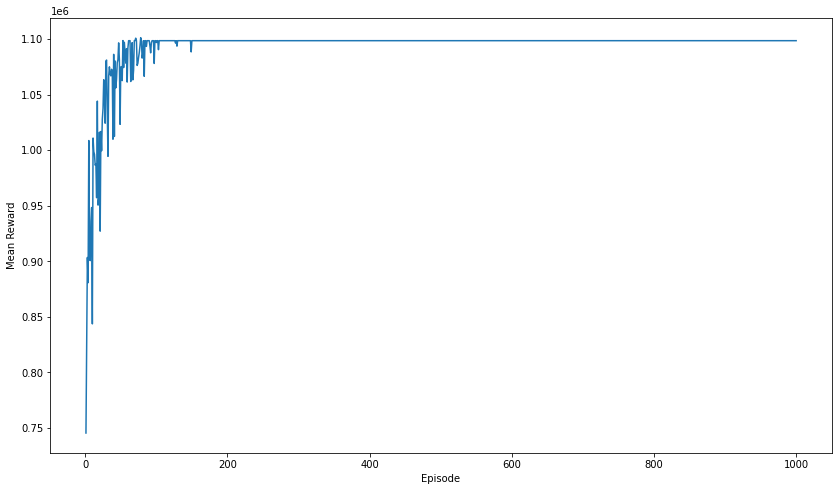

In [14]:
plt.plot(np.arange(1, episodes + 1), cum_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean Reward")

### RL vs Greedy strategy

In this section you should compare policy (function of time), which your agent has learned, with greedy policy, which maximizes 1-step reward. Greedy policy can be found analytically, assuming complete knowledge of the environment. To compute greedy policy use prime_cost and parameters from forecasting model (seasonality, bias and intercept). Note that your reward function is a profit (check the environment).

Our model: $$S(t, p) = k_0 + k_1 p + s(t) + \epsilon$$. 

$$R(t, p) = S(t, p) * (p - c_p), $$ where $c_p$ - prime_cost.

$$R(t, p) = (k_0 + k_1 p + s(t) + \epsilon) * (p - c_p) = \\ = p^2 k_1 + p * (k_0 - k_1 c_p + s(t) + \epsilon) - c_p (k_0 + s(t) + \epsilon)$$.

This is a simple quaratic form, we knoe that its maximum would be at: $\frac{-b}{2a}$.

Thus optimal value: $$-\frac{(k_0 - k_1 c_p + s(t) + \epsilon)}{2 * k_1}$$

In [19]:
vars(sales_predictor.residuals_model)

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['prices', 'week'], dtype=object),
 'n_features_in_': 2,
 'coef_': array([[-0.1396891 , -0.07773937]]),
 '_residues': array([27832.60280456]),
 'rank_': 2,
 'singular_': array([2108.74921469,  216.26506376]),
 'intercept_': array([127.51288757])}

In [35]:
def greedy_action(t):
    s = sales_predictor.seasonal
    try:
        prices_c, week_c =  sales_predictor.residuals_model.coef_
    except:
        prices_c, week_c =  sales_predictor.residuals_model.coef_[0]
    intercept = sales_predictor.residuals_model.intercept_

    p_opt = - (intercept - prices_c * prime_cost - week_c * t + s[t]) / (2 * prices_c)
    
    
    return max(min_price, min(p_opt.item(), max_price))
    

Visualize greedy policy and agent's policy. Can you explain why they're pretty much the same?

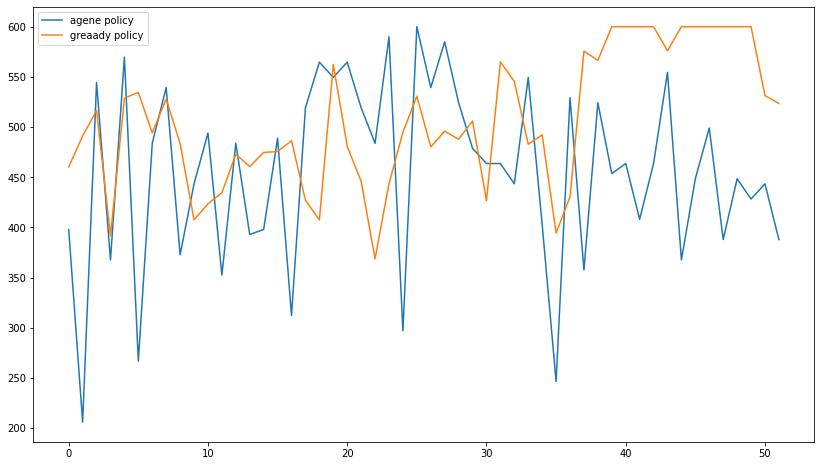

In [37]:
apol = [agent.bins[np.argmax(agent.q[week])] for week in range(52)]
gpol = np.array([greedy_action(week) for week in range(52)])

plt.plot(apol, label="agene policy")
plt.plot(gpol, label="greaady policy")
plt.legend()

## Explanation:
- as sales predictor works from assumption that sales are independe in each moment of time, optimal policy of q-learning upon convergence will be the same as greedy